### TopN Simple Wines Recommender System From A Wine Name
#### Rogério Xavier de Azambuja (rogerio.xavier@farroupilha.ifrs.edu.br)
#### Dataset X-Wines from https://github.com/rogerioxavier/X-Wines

In [1]:
# Opening required packages for processing
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix as csr
from sklearn.neighbors import NearestNeighbors as nn
# Opening required packages to show output
from matplotlib import pyplot as plt
import cv2 as cv

In [2]:
# Opening X-Wines dataset
wines   = pd.read_csv("XWines_100K_wines.csv", low_memory=False, encoding="utf-8", memory_map=True)
ratings = pd.read_csv("XWines_21M_ratings.csv", low_memory=False, encoding="utf-8", memory_map=True)
len(wines), len(ratings)

(100646, 21013536)

In [3]:
print("Total wines:", wines.WineID.nunique(), "from", wines.Code.nunique() ,"different countries")
print("Total users:", ratings.UserID.nunique(), "who rated the wines")
print(f"             in the period between {ratings.Date.min()} and {ratings.Date.max()}")
print("Total ratings:", len(ratings), f"5-stars on wine vintages since {ratings.Vintage.min()}, including non-vintage 'N.V.'")

Total wines: 100646 from 62 different countries
Total users: 1056079 who rated the wines
             in the period between 2012-01-03 08:20:53 and 2021-12-31 23:59:56
Total ratings: 21013536 5-stars on wine vintages since 1950, including non-vintage 'N.V.'


In [4]:
# A first segmentation because the dataset is too big
code = 'PT'
country = 'Portugal'

In [5]:
winesCode = wines.loc[ wines.Code==code ]
print(winesCode.WineID.nunique(), f"wines from the country {country}({code}) ")

4964 wines from the country Portugal(PT) 


In [6]:
# Data preparation for wine recommendation
ratingsCountry = pd.merge(ratings, winesCode.WineID, how="inner", on=['WineID'])
ratingsCountry = ratingsCountry.sort_values(['Date'], ascending=False)
ratingsCountry = ratingsCountry.drop_duplicates(subset=['UserID', 'WineID'], keep='first')
print(len(ratingsCountry), f"unique last user ratings about {code} wines")

1312849 unique last user ratings about PT wines


In [7]:
# Cut-off point for training on the most relevant data
mostRatingsWines = ratingsCountry.groupby('WineID', as_index=False)['Rating'].count()
mostRatingsWines.rename(columns={'Rating':'Frequency'}, inplace=True)
mostRatingsWines = mostRatingsWines.loc[ mostRatingsWines.Frequency>50 ] # optional minimum value
print(len(mostRatingsWines), "most ratings wines")

mostRatingsUsers = ratingsCountry.groupby('UserID', as_index=False)['Rating'].count()
mostRatingsUsers.rename(columns={'Rating':'Frequency'}, inplace=True)
mostRatingsUsers = mostRatingsUsers.loc[ mostRatingsUsers.Frequency>25 ] # optional minimum value
print(len(mostRatingsUsers), "most ratings users")

3452 most ratings wines
5528 most ratings users


In [8]:
# Data segmentation for collaborative filtering
collabRatings = pd.merge(ratingsCountry,  mostRatingsWines.WineID, how="inner", on=['WineID'])
print(collabRatings.WineID.nunique(), "most ratings wines")
collabRatings = pd.merge(collabRatings, mostRatingsUsers.UserID, how="inner", on=['UserID'])
print(collabRatings.UserID.nunique(), "most ratings users")
print(len(ratingsCountry),'to', len(collabRatings), 'useful ratings for collaborative filtering')

3452 most ratings wines
5528 most ratings users
1312849 to 267735 useful ratings for collaborative filtering


In [9]:
# Data matrix for collaborative filtering
collabRatings = collabRatings.pivot(index='WineID', columns='UserID', values='Rating').fillna(0)
print("Sparse matrix dimension: ", collabRatings.shape)
collabRatings.head()

Sparse matrix dimension:  (3432, 5528)


UserID,1000002,1000004,1000010,1000025,1000045,1000049,1000058,1000064,1000065,1000085,...,2056118,2056577,2057551,2057813,2060099,2060555,2061799,2061816,2062178,2062382
WineID,,,,,,,,,,,,,,,,,,,,,
100010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
100012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100014,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101563,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Best treatment for sparse matrix through spicy csr_matrix
collabMatrix = csr(collabRatings.values)
# network training using basic parameters and only collaboration values
collabKNN = nn(n_neighbors=15, metric='cosine', n_jobs=-1)
collabKNN.fit(collabMatrix)
# reset the first UserID index because only wines will be recommended
# makes the indices one-dimensional equivalent to collabMatrix position
collabRatings.reset_index(inplace=True)

In [11]:
# TopN simple recommender from a wine name
def recommenderKNN(wineName='', nRecommendation=10):
    listWines = winesCode.loc[ winesCode.WineName.str.contains(wineName, case=False) ][:3]
    if len(listWines) == 0:
        print("Bad input to find wines")
        return (pd.DataFrame())
    else:
        for i in range(0,3):
            try:
                # from the first wine found
                wineID       = listWines.iloc[i]['WineID']
                # your position in the network
                indexWine    = collabRatings.loc[ collabRatings.WineID == wineID ].index[0]
                break
            except:
                continue
        # capture the index of its topN nearest neighbors
        similarities, indexes = collabKNN.kneighbors(collabMatrix[indexWine], n_neighbors=nRecommendation+1)
        # return the neighbors using their indexes and similarity
        recList = []
        for (s, i) in zip(similarities[0], indexes[0]):
            wineID = int(collabRatings.iloc[ i ]['WineID'])
            wine = winesCode.loc[ winesCode.WineID == wineID ][['WineID', 'WineName']].values[0]
            recList.insert(0, {'WineID':wine[0], 'WineName':wine[1], 'Similarity':round(s, 5)})
        recList.sort(key=lambda i: i['Similarity'], reverse=True)
        return (pd.DataFrame(recList))

def show10wines(df=pd.DataFrame()):
    if len(df) == 0:
        print("Bad input to show wines")
        return 
    else:
        if len(df)==1:
            plt.figure(figsize=(25, 10))
            titlesize = 25
        else:
            plt.figure(figsize=(50, 20))
            titlesize = 40
        i = 1
        for (wineID, wineName) in (zip(df.WineID[:10], df.WineName[:10])):
            plt.subplot(2,5,i), plt.imshow( cv.imread(f"images/{wineID}.jpeg",1) )
            plt.title("\n"+wineName, fontsize=titlesize)
            plt.xticks([]),plt.yticks([])
            i+=1
        plt.show()       
        return

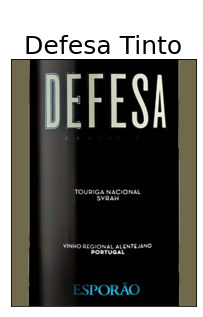

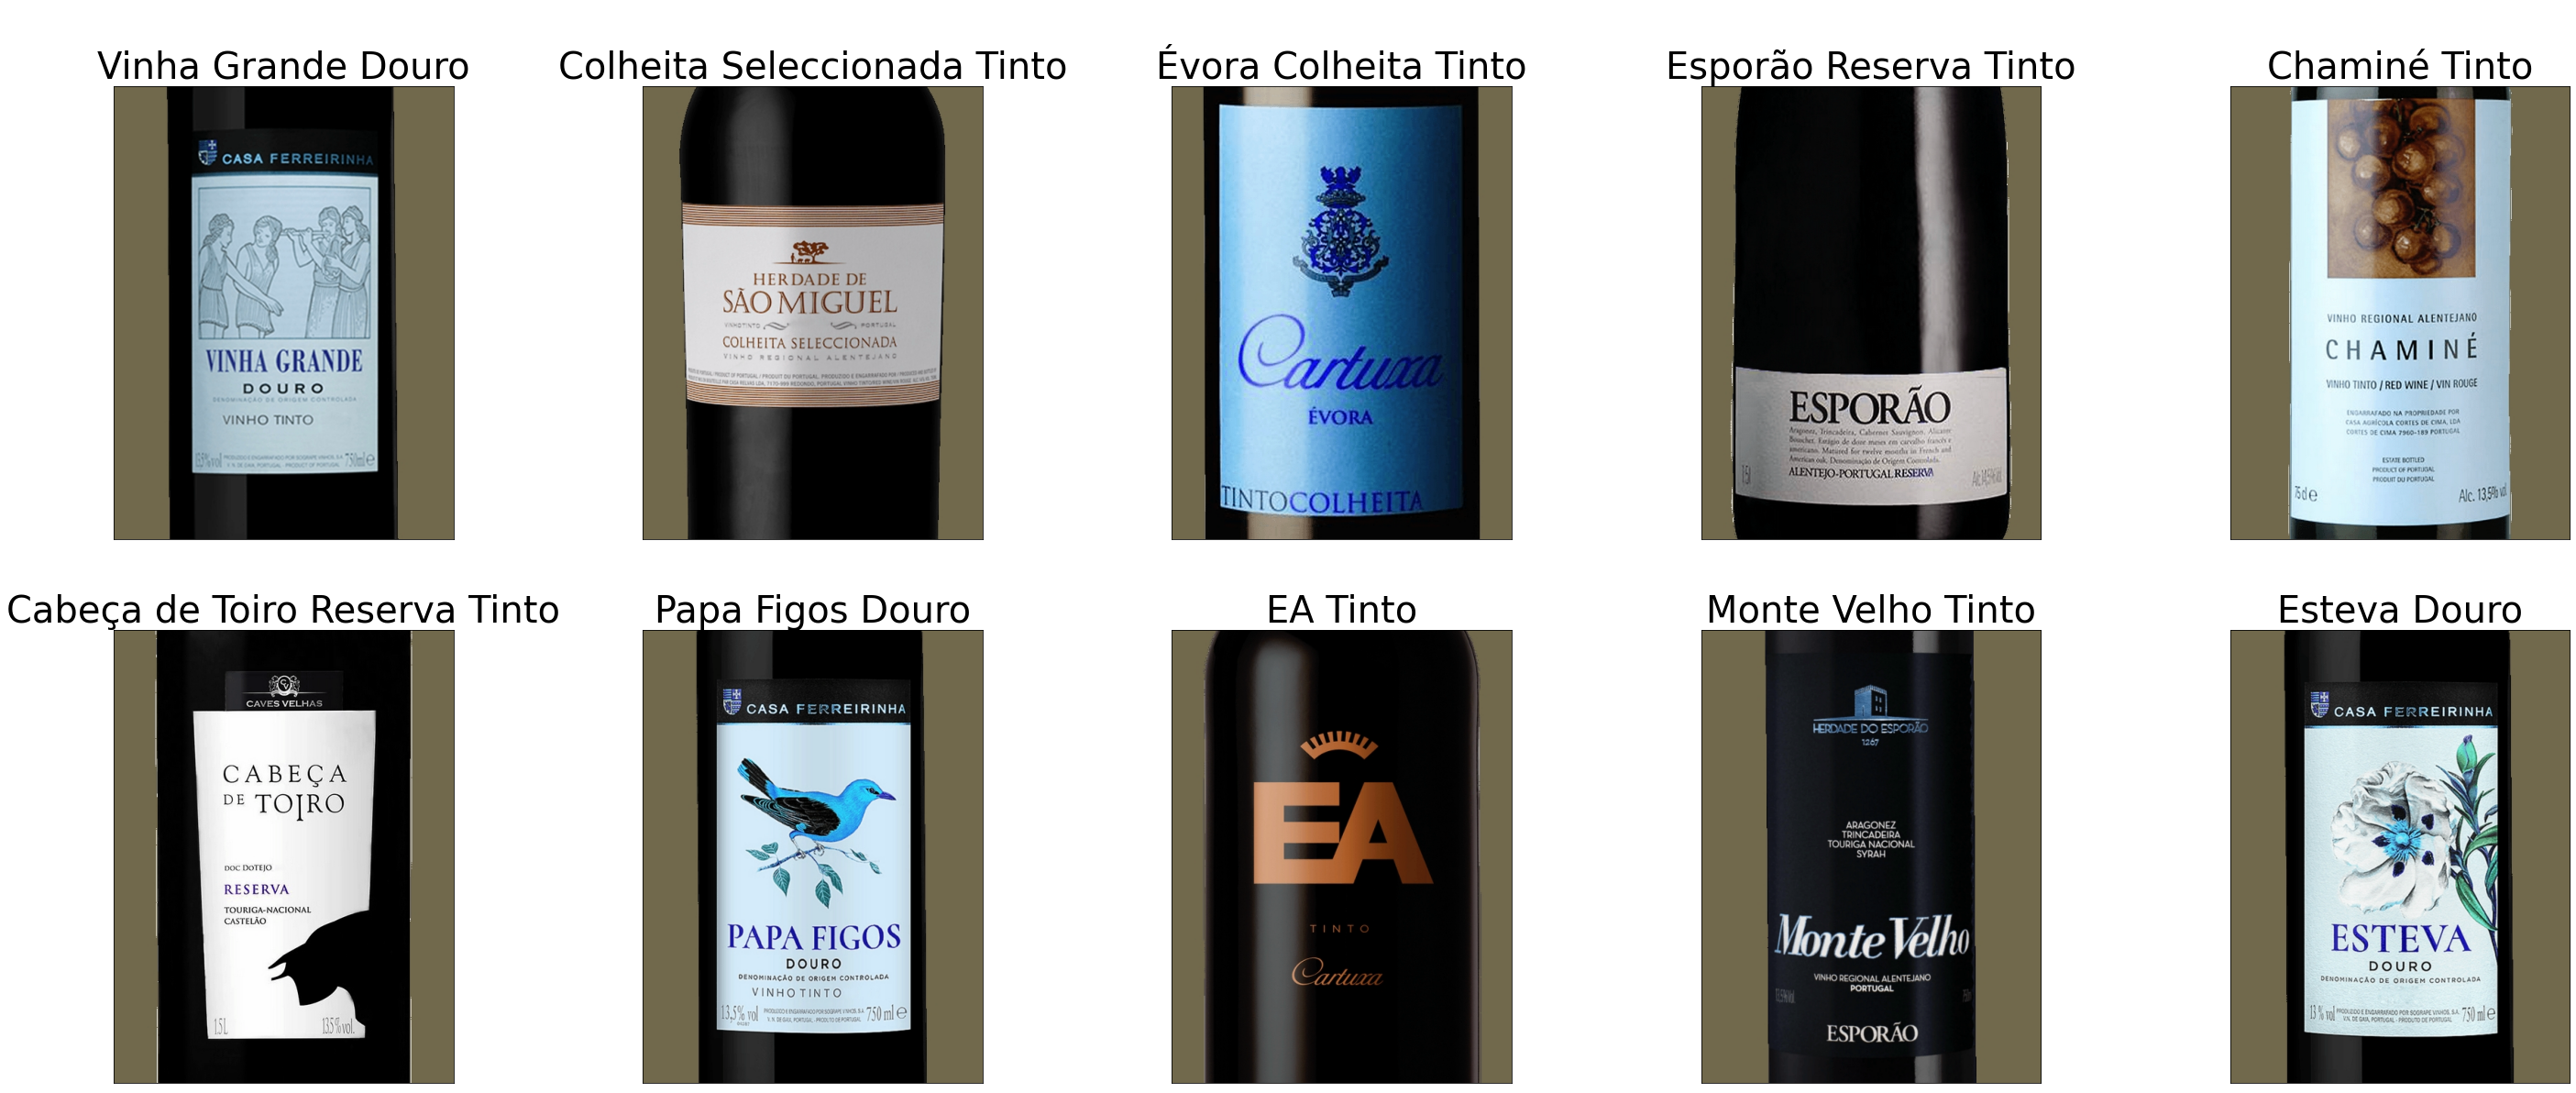

,WineID,WineName,Similarity
0,101599,Vinha Grande Douro,0.84024
1,101593,Colheita Seleccionada Tinto,0.83433
2,101565,Évora Colheita Tinto,0.83278
3,101563,Esporão Reserva Tinto,0.83251
4,101582,Chaminé Tinto,0.82813
5,101613,Cabeça de Toiro Reserva Tinto,0.82220
6,101564,Papa Figos Douro,0.82180
7,101573,EA Tinto,0.82005
8,101566,Monte Velho Tinto,0.80292
9,101569,Esteva Douro,0.78836


In [12]:
topN = 10; wineStartName = "Defesa"
recommendedWines = recommenderKNN(wineStartName, topN)
# The last wine in the list is the starting wine with similarity = 0
show10wines(recommendedWines[topN:])
# Shows recommended wines
show10wines(recommendedWines[:topN])
recommendedWines.head(topN)

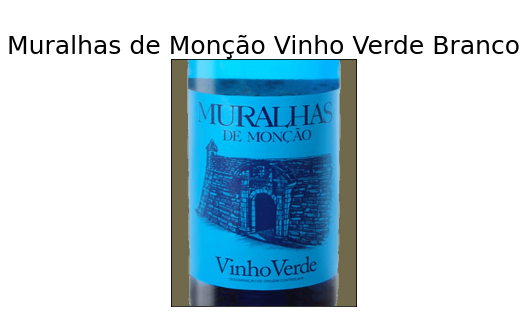

5 recommendations considering wine: 101596 Muralhas de Monção Vinho Verde Branco 

   WineID                        WineName  Similarity
0  101635  Vinho Verde Loureiro-Alvarinho     0.80952
1  101575                       Alvarinho     0.80382
2  101591   Planalto Reserva Douro Branco     0.80340
3  101569                    Esteva Douro     0.79926
4  101564                Papa Figos Douro     0.79285


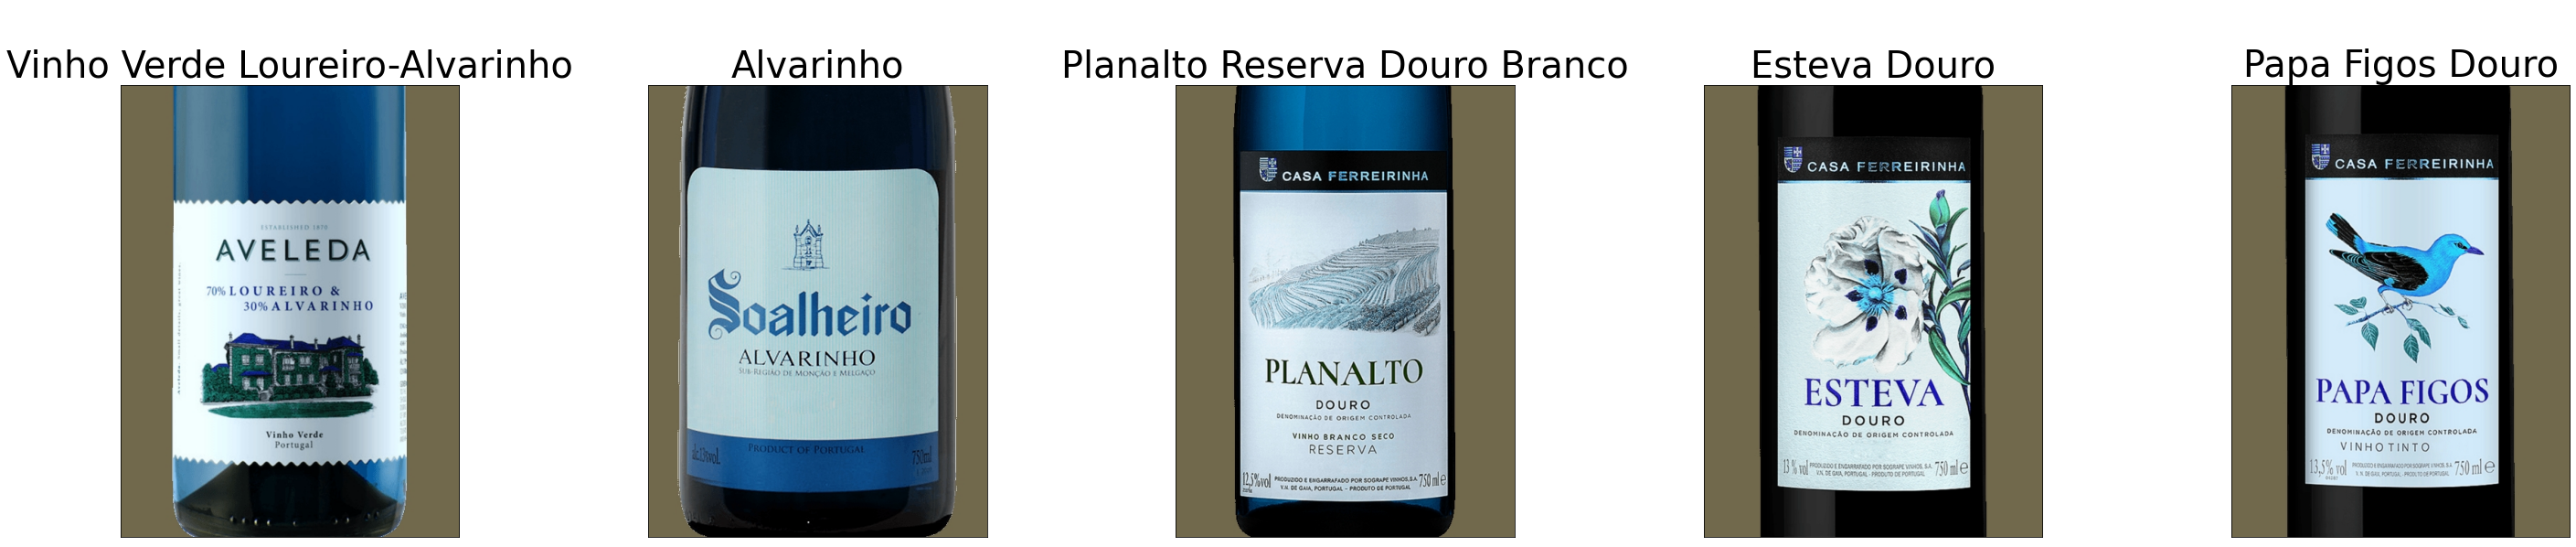

In [13]:
topN = 5; wineStartName = "Vinho Verde Branco"
recommendedWines = recommenderKNN(wineStartName, topN)
if len(recommendedWines)>0:
    # The last wine in the list is the starting wine with similarity = 0
    show10wines(recommendedWines[topN:])
    print(topN,'recommendations considering wine:',recommendedWines.WineID[topN],recommendedWines.WineName[topN],"\n")
    # Shows recommended wines
    print(recommendedWines.head(topN))
    show10wines(recommendedWines[:topN])